# Vision models

## Orientation: ResNet-18


1. Let's start by training a simple ResNet-18 model and take lots of checkpoints.
2. Then do feature visualization on the end results (for a random sample of neurons). 
3. Look at how the activation of the target neuron reacts to those feature visualizations over the course of training.

In [60]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import torchvision
import torchvision.utils as vutils
from PIL import Image
from tqdm.notebook import tqdm
import os
from dataclasses import dataclass, field
from typing import Optional, Container, Tuple
from dataclasses import asdict
import math
import numpy as np

from dotenv import load_dotenv

load_dotenv("../.env")

True

In [7]:
torch.manual_seed(0)
model: nn.Module = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=False)

Using cache found in /Users/Jesse/.cache/torch/hub/pytorch_vision_v0.10.0
/Users/Jesse/Projects/devinterp/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/Jesse/Projects/devinterp/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [5]:
# Data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
train_set = datasets.CIFAR10(root='../data', train=True, download=True, transform=transform)
test_set = datasets.CIFAR10(root='../data', train=False, download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [6]:
@dataclass
class Config:
    batch_size: int = 128
    lr: float = 0.01  # Starting lr
    weight_decay: float = 0.0001
    num_epochs: Optional[int] = None
    logging_steps: Optional[Container] = None
    project: Optional[str] = None
    entity: Optional[str] = None
    device: torch.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    betas: Tuple[float, float] = (0.9, 0.999)

    def __post_init__(self):
        if self.num_epochs is None:
            # Default to 64k steps
            self.num_epochs = 64000 * self.batch_size // len(train_set)

        if self.logging_steps is None or isinstance(self.logging_steps, int):
            logging_steps = self.logging_steps
            # By default: 1x per epoch
            self.logging_steps = set([i * len(train_set) // self.batch_size for i in range(self.num_epochs)]) 

            if isinstance(logging_steps, int):
                # Logscale from with self.logging_steps steps between 0 and num_epochs * len(train_data) // self.batch_size
                self.logging_steps |= {int(i) for i in np.logspace(0, np.log10(self.num_epochs * len(train_set) // self.batch_size), logging_steps)}
                
config = Config(project="resnet18", entity="devinterp", logging_steps=100)
steps = sorted(list(config.logging_steps))
config

Config(batch_size=128, lr=0.01, weight_decay=0.0001, num_epochs=163, logging_steps={0, 1, 37890, 2, 3, 4, 23046, 5, 6, 60937, 7, 8203, 8, 46093, 9, 10, 11, 521, 31250, 13, 14, 16, 16406, 18, 54296, 20, 1562, 22, 25, 39453, 28, 31, 24609, 35, 62500, 9765, 1019, 39, 47656, 32812, 44, 3117, 17968, 49, 14897, 55859, 3125, 41015, 55, 1594, 26171, 62, 11328, 49218, 36418, 69, 34375, 583, 19531, 57421, 78, 4687, 42578, 27734, 87, 12890, 50781, 35937, 97, 21093, 58984, 6250, 56939, 44140, 109, 29296, 1140, 14453, 52343, 122, 37500, 22656, 60546, 7812, 45703, 136, 11914, 30859, 652, 16015, 53906, 1171, 39062, 152, 24218, 62109, 6814, 9375, 47265, 32421, 17578, 170, 55468, 2734, 40625, 25781, 2229, 63670, 10937, 48828, 190, 33984, 19140, 18628, 57031, 4296, 42187, 27343, 12500, 213, 50390, 729, 35546, 20703, 58593, 5859, 2787, 43750, 50920, 28906, 14062, 238, 51953, 37109, 1783, 22265, 1275, 60156, 7421, 23292, 45312, 30468, 4358, 15625, 4873, 53515, 266, 781, 38671, 16658, 40723, 23828, 61718, 

In [56]:
def maybe_initialize_wandb(project_name: Optional[str] = None, entity: Optional[str] = None):
    if project_name:
        import wandb
        wandb.init(project=project_name, entity=entity)
        return wandb
    return None

wandb = maybe_initialize_wandb(config.project, config.entity)

Batch/Loss,▆▆▃▃█▆▅▃▃▄▅▃▃▃▁▃▄▂▃▃▃▂▃▃▃▂▂▃▅▂▃▄▂▃▂▃▃▂▂▃
Batch/Loss,1.45581


In [7]:
from torch.optim.lr_scheduler import LambdaLR
from torch import optim

optimizer = optim.Adam(model.parameters(), lr=config.lr, weight_decay=config.weight_decay, betas=config.betas)
scheduler = LambdaLR(optimizer, milestones=[16_000, 32_000, 48_000], gamma=0.5) 

torch.manual_seed(1)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=config.batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=config.batch_size, shuffle=False)

TypeError: __init__() got an unexpected keyword argument 'milestones'

In [62]:
import logging
import boto3
from botocore.exceptions import ClientError
import os


def upload_file(file_name, bucket_name = 'devinterp', object_name=None):
    s3_client = boto3.client('s3')

    if object_name is None:
        object_name = file_name
    s3_client.upload_file(file_name, bucket_name, object_name)
    

In [58]:
def train(model: torch.nn.Module, train_loader: torch.utils.data.DataLoader, optimizer: torch.optim.Optimizer, scheduler, logging_steps: set,device: torch.device, num_epochs=10, project="resnet18", **kwargs):
    model.train()

    # Calculate total number of batches
    num_batches_per_epoch = len(train_loader)
    total_batches = num_batches_per_epoch * num_epochs

    pbar = tqdm(total=total_batches, desc=f"Epoch 0 Batch 0/{total_batches} Loss: ?.??????")
    
    for epoch in range(1, num_epochs + 1):
        for _batch_idx, (data, target) in enumerate(train_loader, 1):  # Start batch_idx from 1
            batch_idx = num_batches_per_epoch * epoch + _batch_idx
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = F.cross_entropy(output, target)
            loss.backward()
            optimizer.step()
            scheduler.step()
            
            # Update progress bar description
            pbar.set_description(f"Epoch {epoch} Batch {batch_idx}/{total_batches} Loss: {loss.item():.6f}")
            pbar.update(1)
            
            if wandb:
                wandb.log({"Batch/Loss": loss.item()}, step=batch_idx)

            # Log to wandb & save checkpoints according to log_steps
            if batch_idx in logging_steps:
                checkpoint_name = f"../checkpoints/{project}/checkpoint_epoch_{epoch}_batch_{batch_idx}.pt"
                torch.save(model.state_dict(), checkpoint_name)
                upload_file(checkpoint_name)
                os.remove(checkpoint_name)
        
        pbar.close()


In [54]:
train(model, train_loader, optimizer, scheduler, **asdict(config))

Epoch 0 Batch 0/63733 Loss: ?.??????:   0%|          | 0/63733 [00:00<?, ?it/s]

KeyboardInterrupt: 

# Feature visualization

We have a trained `model` (and a bunch of checkpoints). First, let's do some classic feature visualization on the final network. We'll select a few random neurons from ac

In [58]:
state_dict = torch.load('../checkpoints/resnet18/checkpoint_epoch_137_batch_53906.pt')
model.load_state_dict(state_dict)
# model: nn.Module = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)
# model: nn.Module = torch.hub.load('pytorch/vision:v0.10.0', 'inception_v1', pretrained=True)
model

RuntimeError: PytorchStreamReader failed reading zip archive: failed finding central directory

Location: layer1.0.conv1.3.3.3


Optimizing...:   0%|          | 0/900 [00:00<?, ?it/s]

Iteration: 0, Activation: -0.8998583555221558
Iteration: 100, Activation: 4.3984246253967285
Iteration: 200, Activation: 8.698835372924805
Iteration: 300, Activation: 12.645537376403809
Iteration: 400, Activation: 16.397750854492188
Iteration: 500, Activation: 20.09567642211914
Iteration: 600, Activation: 23.49847412109375
Iteration: 700, Activation: 26.673416137695312
Iteration: 800, Activation: 29.670045852661133


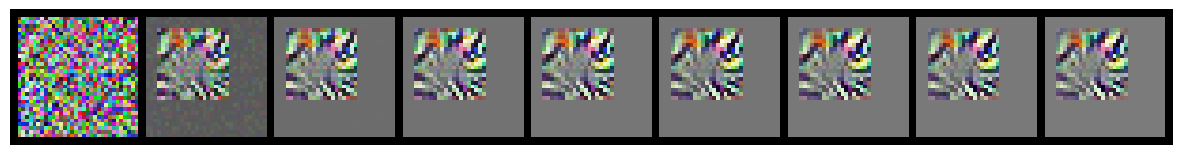

Location: layer1.0.conv2.3.3.3


Optimizing...:   0%|          | 0/900 [00:00<?, ?it/s]

Iteration: 0, Activation: 0.21320819854736328
Iteration: 100, Activation: 3.6224400997161865
Iteration: 200, Activation: 6.827873229980469
Iteration: 300, Activation: 9.763675689697266
Iteration: 400, Activation: 12.363964080810547
Iteration: 500, Activation: 14.654808044433594
Iteration: 600, Activation: 16.76792335510254
Iteration: 700, Activation: 18.709842681884766
Iteration: 800, Activation: 20.461708068847656


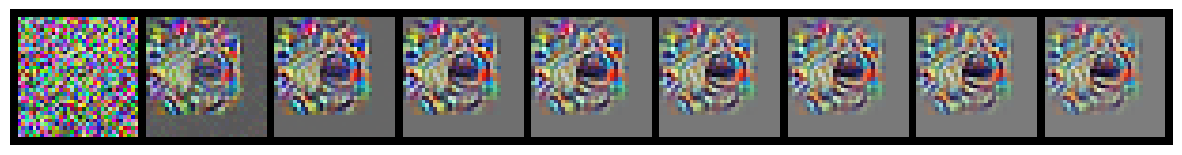

Location: layer1.1.conv1.3.3.3


Optimizing...:   0%|          | 0/900 [00:00<?, ?it/s]

Iteration: 0, Activation: -1.3761903047561646
Iteration: 100, Activation: 4.329487323760986
Iteration: 200, Activation: 7.070468902587891
Iteration: 300, Activation: 9.869524002075195
Iteration: 400, Activation: 12.982312202453613
Iteration: 500, Activation: 16.196456909179688
Iteration: 600, Activation: 19.31904411315918
Iteration: 700, Activation: 22.150711059570312
Iteration: 800, Activation: 24.813968658447266


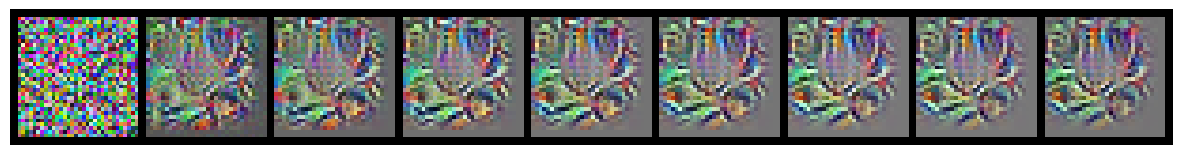

Location: layer1.1.conv2.3.3.3


Optimizing...:   0%|          | 0/900 [00:00<?, ?it/s]

Iteration: 0, Activation: -0.11203254759311676
Iteration: 100, Activation: 3.053316116333008
Iteration: 200, Activation: 4.297069072723389
Iteration: 300, Activation: 5.615730285644531
Iteration: 400, Activation: 6.894990921020508
Iteration: 500, Activation: 8.080615043640137
Iteration: 600, Activation: 9.373477935791016
Iteration: 700, Activation: 10.451269149780273
Iteration: 800, Activation: 11.477252960205078


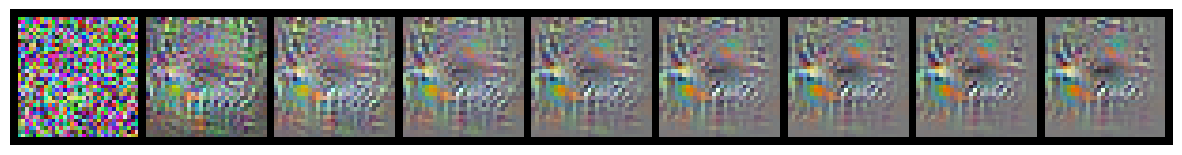

Location: layer2.0.conv1.3.3.3


Optimizing...:   0%|          | 0/900 [00:00<?, ?it/s]

Iteration: 0, Activation: 1.5675084590911865
Iteration: 100, Activation: 12.498132705688477
Iteration: 200, Activation: 16.266382217407227
Iteration: 300, Activation: 20.643285751342773
Iteration: 400, Activation: 25.446182250976562
Iteration: 500, Activation: 30.570138931274414
Iteration: 600, Activation: 35.934383392333984
Iteration: 700, Activation: 41.16099548339844
Iteration: 800, Activation: 46.385345458984375


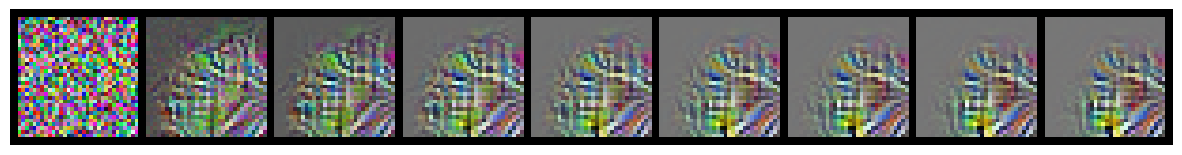

Location: layer2.0.conv2.3.3.3


Optimizing...:   0%|          | 0/900 [00:00<?, ?it/s]

Iteration: 0, Activation: -0.16666273772716522
Iteration: 100, Activation: 2.0422422885894775
Iteration: 200, Activation: 2.4368059635162354
Iteration: 300, Activation: 2.6936028003692627
Iteration: 400, Activation: 2.8873097896575928
Iteration: 500, Activation: 3.0453433990478516
Iteration: 600, Activation: 3.176210641860962
Iteration: 700, Activation: 3.297614812850952
Iteration: 800, Activation: 3.3944246768951416


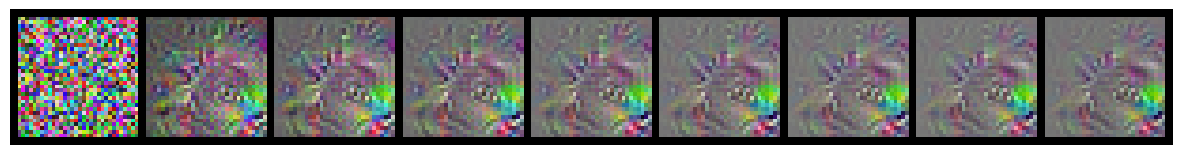

In [57]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt

class ActivationExtractor:
    def __init__(self, location):
        self.location = location.split('.')
        self.activation = None

    def hook_fn(self, module, input, output):
        c, y, x = map(int, self.location[-3:])
        self.activation = output[0, c, y, x]

    def register_hook(self, model):
        layer = model
        for part in self.location[:-3]:
            layer = getattr(layer, part)
        handle = layer.register_forward_hook(self.hook_fn)
        return handle

def show_image(image: torch.Tensor):
    # Process the optimized input
    optimized_input = image.detach().cpu().squeeze()
    # normalized_input = transforms.Normalize(mean=[-0.485 / 0.229, -0.456 / 0.224, -0.406 / 0.225],
    #                                         std=[1 / 0.229, 1 / 0.224, 1 / 0.225])(optimized_input)
    # optimized_image = transforms.ToPILImage()(normalized_input)
    optimized_image = transforms.ToPILImage()(optimized_input)

    # Display the optimized image
    plt.imshow(optimized_image)
    plt.show()


def add_jitter(input_image, jitter_amount=2):
    """Applies jitter by randomly shifting the image."""
    if not jitter_amount:
        return input_image

    x_shift, y_shift = torch.randint(jitter_amount, -jitter_amount, (2,))
    return torch.roll(input_image, shifts=(x_shift, y_shift), dims=(2, 3))

def render(model: nn.Module, location: str, thresholds: list[int]=[512], verbose: bool = True):
    # Assuming 'model' is your pre-trained ResNet model and 'location' is the string specifying the neuron's location
    model = model.eval()
    extractor = ActivationExtractor(location)
    handle = extractor.register_hook(model)

    # Create a random image (1x3x224x224) to start optimization, with same size as typical ResNet input
    input_image = torch.rand((1, 3, 32, 32), requires_grad=True)

    # Optimizer
    optimizer = optim.Adam([input_image], lr=0.01, weight_decay=1e-3)
    jitter_amount = 0

    final_images = []

    # Optimization loop
    for iteration in tqdm(range(max(thresholds)), desc="Optimizing..."):
        optimizer.zero_grad()
        model(input_image)  # Forward pass through the model to trigger the hook
        activation = extractor.activation
        loss = -activation  # Maximizing activation
        loss.backward()
        optimizer.step()

        input_image.data = add_jitter(input_image.data.detach().clone(), jitter_amount=-jitter_amount)


        if iteration in thresholds:
            print(f'Iteration: {iteration}, Activation: {activation.item()}')

            if verbose:
                show_image(input_image)

            image = input_image.detach().clone()
            # Make sure the image has shape (1, 3, 32, 32) and is in the correct range

            image = torch.reshape(image, (1, 3, 32, 32))            

            final_images.append(image)

    handle.remove()  # Remove the hook after the loop

    return final_images


random_neurons = [
    'layer1.0.conv1.3.3.3',
    'layer1.0.conv2.3.3.3',
    'layer1.1.conv1.3.3.3',
    'layer1.1.conv2.3.3.3',
    'layer2.0.conv1.3.3.3',
    'layer2.0.conv2.3.3.3',
]

for location in random_neurons:
    print(f'Location: {location}')
    images = render(
        model, 
        location = location,
        thresholds = [0, 100, 200, 300, 400, 500, 600, 700, 800, 900],
        verbose = False,
    )

    def show_all_images(images):
        # Normalize images to [0,1] and create grid
        images = [img - img.min() for img in images]
        images = [img / img.max() for img in images]
        images = [img.squeeze(0) for img in images]
        
        # Create grid
        grid_image = vutils.make_grid(images, nrow=len(images))

        # Convert to numpy and transpose for plotting
        grid_image_np = grid_image.mul(255).add_(0.5).clamp_(0, 255).permute(1, 2, 0).to('cpu', torch.uint8).numpy()

        # Display using matplotlib
        plt.figure(figsize=(15, 30))  # You can change the size as you prefer
        plt.imshow(grid_image_np)
        plt.axis('off') # to remove the axis
        plt.show()
        
    show_all_images(images)
    